<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/PSF_estimation_after_registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ホモグラフィ変換およびPSF (point spread function)の推定

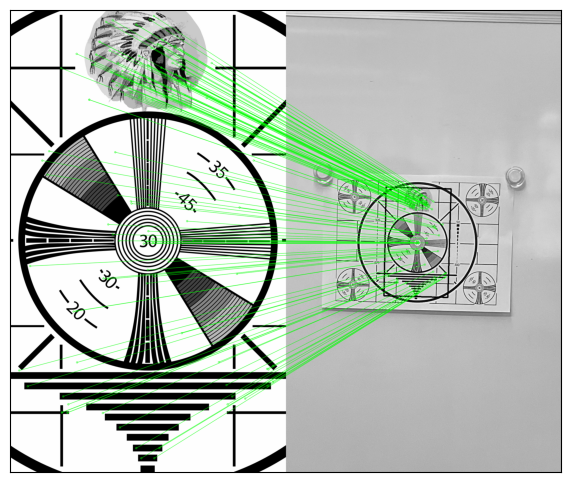

<br>

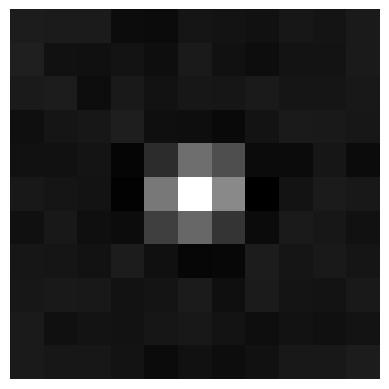
<br>

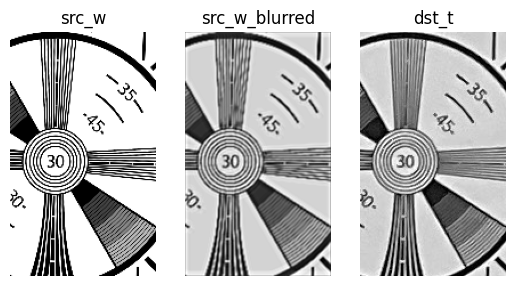


## データの読み込み

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
use_cuda: bool = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

import torchvision.io as io
from torchvision.transforms import functional as ttf

def bchw_from_center_crop(paths, hw=(1204,1204), dhw=(0,0)):
    hw, dhw = torch.tensor(hw), torch.tensor(dhw)
    if hw.dim() == 1: hw = hw.expand(len(paths), -1)
    if dhw.dim() == 1: dhw = dhw.expand(len(paths), -1)
    images = []
    for b, path in enumerate(paths):
        img = io.read_image(path).expand(3,-1,-1).to(torch.float64) / 255
        h, w = img.shape[1], img.shape[2]
        crop_top = int(((h - hw[b][0]) // 2) + dhw[b][0])
        crop_left = int(((w - hw[b][1]) // 2) + dhw[b][1])
        img = ttf.crop(img, crop_top, crop_left, hw[b][0], hw[b][1])
        #img = ttf.center_crop(img, hw)
        images.append(img)
    return torch.stack(images)

def rgb_to_gray(images):
    if images.shape[1] == 1: return images
    luminance_weights = torch.tensor([0.2989, 0.5870, 0.1140]).view(1, 3, 1, 1).to(images.device.type)
    return torch.sum(images * luminance_weights, dim=1, keepdim=True)
    #images.detach().cpu()

import matplotlib.pyplot as plt
def gimshow(images, cmap='viridis'):   # (b, c, h, w)
    if images.shape[1] == 1: cmap = 'gray'
    if cmap == 'gray':
        images = rgb_to_gray(images.detach().cpu())
    image = images.permute(1,2,0,3).contiguous().view(images.shape[1], images.shape[2], -1)
    plt.imshow(image.detach().cpu().permute(1,2,0), cmap=cmap)
    plt.axis('off')  # Hide the axis
    plt.show()

cpu


torch.Size([2, 1, 1716, 1024])


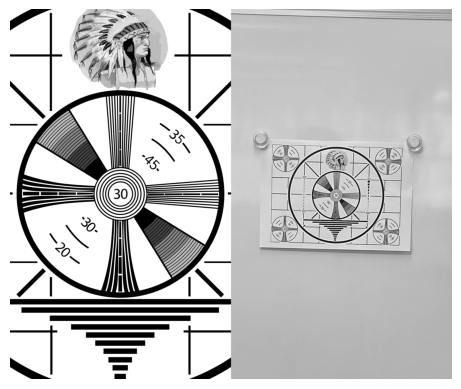

In [ ]:
# 読み込む画像の場所（変換前の画像，変換後の画像（写真））
paths = [
    "/content/drive/MyDrive/indian_head/2560px-RCA_Indian_Head_Test_Pattern.svg.png",
    "/content/drive/MyDrive/indian_head/IMG_150cm_2.jpg"
    ]

# (h, w): 読み込みたい中央付近の領域の高さと幅
# (dh, dw): 位置の中央からのずれ
h, w, dh, dw = 1204+512, 1024, -256, 0
images = bchw_from_center_crop(paths, hw=[h, w], dhw = [[0,0], [dh, dw]])

# To estimate PSF with a single channel
is_color_psf = False
if not is_color_psf:
    images = rgb_to_gray(images)

print(images.shape)
gimshow(images, 'gray')

## 対応点に基づくホモグラフィ変換の推定
SIFT keypoints (cv2)

In [ ]:
import numpy as np
import cv2

def find_good_points(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good_points = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good_points.append(m)
    return dict(kp1=kp1, kp2=kp2, good_points=good_points)


def find_homography(kp1, kp2, good_points, min_match_count=10):
    if len(good_points) > min_match_count:
        pts1 = np.float32([ kp1[m.queryIdx].pt for m in good_points ]).reshape(-1,1,2)
        pts2 = np.float32([ kp2[m.trainIdx].pt for m in good_points ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

    else:
        print( "Not enough matches are found - {}/{}".format(len(good_points), min_match_count) )
        matchesMask = None

    return dict(M=M, matchesMask=matchesMask)


def draw_matches(img1, img2, kp1, kp2, good_points, M, matchesMask):

    h,w = img1.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img20 = cv2.polylines(np.ascontiguousarray(img2), [np.int32(dst)], True, (0,255,0), 3)#, cv2.LINE_AA)

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)

    img3 = cv2.drawMatches(img1, kp1, img20, kp2, good_points, None, **draw_params)

    plt.figure(figsize=(12,6))
    plt.xticks([]), plt.yticks([])
    plt.imshow(img3, 'gray')

[[ 2.37100681e-01 -1.83931197e-03  3.71997499e+02]
 [ 8.80730327e-03  2.44990933e-01  6.57526121e+02]
 [ 2.69054318e-06  8.78416328e-06  1.00000000e+00]]
scale, rotation, shift:  0.2549981098674948 0.4444639255303402 [371.99749905 657.52612125]


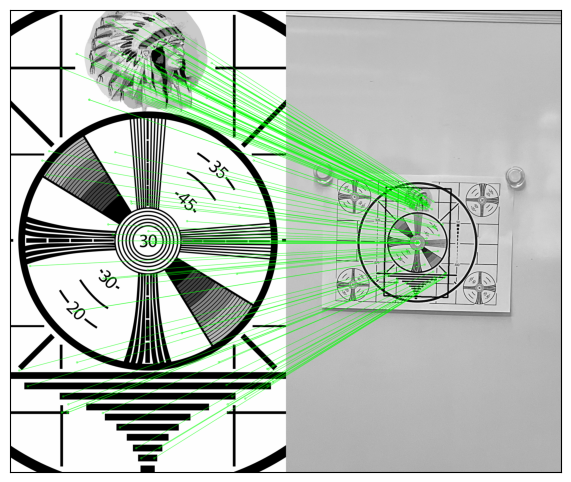

In [ ]:
src = images[0]#.unsqueeze(0).to(device)
dst = images[1]#.unsqueeze(0).to(device)

img_src = (src.permute(1,2,0).numpy()*255).astype("uint8")
img_dst = (dst.permute(1,2,0).numpy()*255).astype("uint8")

gp_res = find_good_points(img_src, img_dst)
homo_res = find_homography(**gp_res)
draw_matches(img_src, img_dst, **gp_res, **homo_res)


M =  homo_res['M']
print(M)

import numpy as np
deg = - np.arctan2(M[0,1], M[0,0]) * 180 / np.pi
scale = np.sqrt(M[0,0]**2+M[1,0**2])
shift = M[:2,2]
print("scale, rotation, shift: ", scale, deg, shift)


In [ ]:
!pip install -q kornia
#!pip install kornia-rs

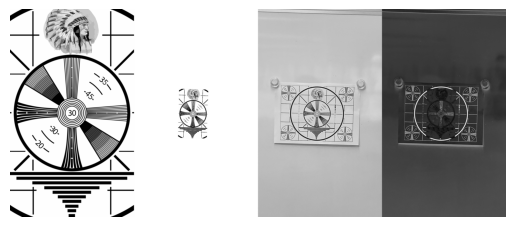

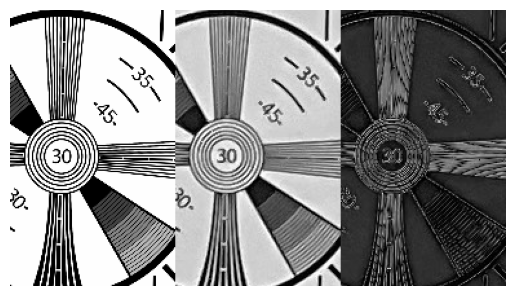

loss = 0.07399568980734035


In [ ]:
src = images[0].expand(1,3,-1,-1).to(device)
dst = images[1].expand(1,3,-1,-1).to(device)

import kornia.geometry as kg
src_warped_filled = kg.transform.warp_perspective(src, torch.tensor(M).unsqueeze(0).to(device),
                                           dst.shape[2:],
                                           mode='bilinear', padding_mode='fill', fill_value=torch.ones(3))
gimshow(torch.cat([src, src_warped_filled, dst, (dst - src_warped_filled).abs()], dim=0))
gimshow(torch.cat([ttf.center_crop(src_warped_filled, (h//8,w//8)),
                   ttf.center_crop(dst, (h//8,w//8)),
                   ttf.center_crop((dst - src_warped_filled).abs(), (h//8,w//8))], dim=0))

import torch.nn.functional as F
#cos = torch.nn.CosineSimilarity()
#cos_loss = lambda x1, x2, reduction: 1.0 - cos(x1, x2).abs()
loss_fn = F.mse_loss
print("loss =", loss_fn(src_warped_filled, dst).item())

## ホモグラフィ変換の微調整
kornia.geometry.ImageRegistrator

In [ ]:
#https://kornia.readthedocs.io/en/latest/geometry.transform.html#kornia.geometry.transform.image_registrator.ImageRegistrator
import torch.optim as optim
import kornia.geometry as kg

class myImageRegistrator(kg.ImageRegistrator):
    def reset_model(self) -> None:
        pass


tensor([[[ 4.2641e+00,  1.8225e-01,  2.0119e-01],
         [-6.7941e-02,  4.2419e+00, -3.5618e-02],
         [-1.6470e-03, -2.7980e-02,  1.0000e+00]]], dtype=torch.float64,
       grad_fn=<UnsqueezeBackward0>)
model.model Parameter containing:
tensor([[ 4.2477e+00,  1.8156e-01,  2.0042e-01],
        [-6.7681e-02,  4.2257e+00, -3.5481e-02],
        [-1.6407e-03, -2.7872e-02,  9.9617e-01]], dtype=torch.float64,
       requires_grad=True)


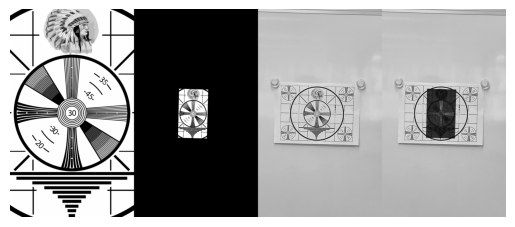

In [ ]:
#warper = kg.transform.HomographyWarper(dst.shape[2], dst.shape[3], mode='bilinear', padding_mode='zeros', normalized_coordinates=False)
registrator = myImageRegistrator("homography", #"similarity",
                                 loss_fn=loss_fn, lr=0.01, optimizer=optim.Adam,
                                 tolerance=1e-4, num_iterations=100,
                                 pyramid_levels=1)#, warper=warper)
Mnormalized = kg.conversions.normalize_homography(torch.tensor(M).unsqueeze(0), (h, w), (h, w))
registrator.model.model = torch.nn.Parameter(torch.inverse(Mnormalized).squeeze(0))#.to(torch.float32))
registrator.to(device)

homo = registrator.register(1.0 - src, 1.0 - dst)
print(homo)
for k, v in registrator.named_parameters():
    print(k, v)
src_warped = registrator.warp_src_into_dst(src)

gimshow(torch.cat([src, src_warped, dst, (dst - src_warped).abs()], dim=0))
#print("loss =", loss_fn(src_warped, dst).item())

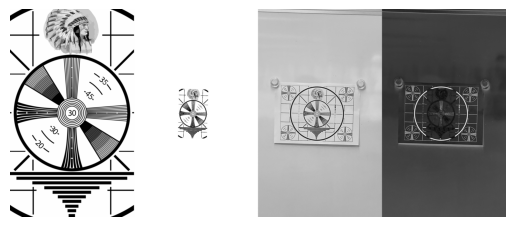

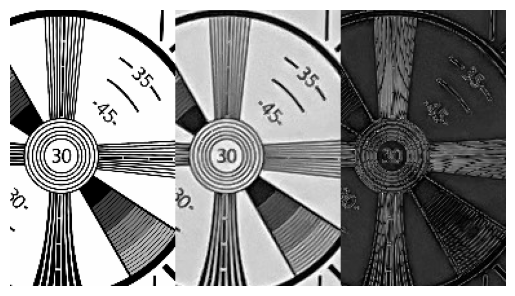

loss = 0.0736899651806909


In [ ]:
src_warped_filled = kg.transform.warp_perspective(src.to(torch.float64),
                                                  kg.conversions.denormalize_homography(torch.inverse(homo), (h,w), (h,w)).to(torch.float64),
                                           dst.shape[2:],
                                           mode='bilinear', padding_mode='fill', fill_value=torch.ones(3))
gimshow(torch.cat([src, src_warped_filled, dst, (dst - src_warped_filled).abs()], dim=0))
gimshow(torch.cat([ttf.center_crop(src_warped_filled, (h//8,w//8)),
                   ttf.center_crop(dst, (h//8,w//8)),
                   ttf.center_crop((dst - src_warped_filled).abs(), (h//8,w//8))], dim=0))
print("loss =", loss_fn(src_warped_filled, dst).item())


## PSFの推定
Minimize loss(model(src_w), dst_t)

torch.Size([1, 1, 214, 128]) torch.Size([1, 1, 214, 128]) cpu
epoch = 0 , loss =  0.2613543606389178
epoch = 200 , loss =  0.0075753944979126625
epoch = 400 , loss =  0.005706570220119567
epoch = 600 , loss =  0.005363511609599701
epoch = 800 , loss =  0.005254114182966381
epoch = 1000 , loss =  0.005223519425048611
16.342476844787598 seconds.
torch.Size([1, 1, 11, 11]) tensor(0.3151, dtype=torch.float64)


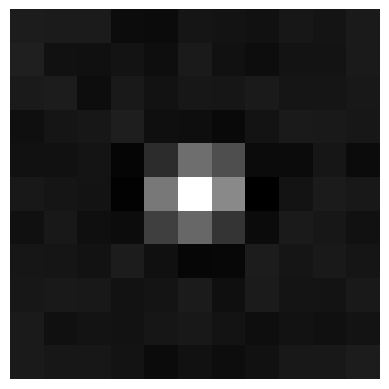

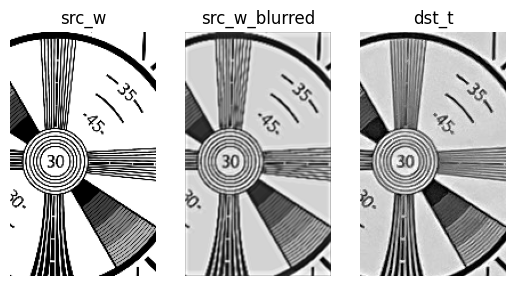

In [ ]:
crop_factor = 8
hc, wc = h // crop_factor, w // crop_factor

src_w = ttf.center_crop(src_warped_filled, (hc,wc))
dst_t = ttf.center_crop(dst, (hc,wc))

cmap = 'viridis'
if not is_color_psf:
    src_w = rgb_to_gray(src_w).detach()
    dst_t = rgb_to_gray(dst_t).detach()
    cmap = 'gray'
src_w.to(device)
dst_t.to(device)
print(src_w.shape, dst_t.shape, src_w.device.type)

import torch.nn as nn
kernel_size = 11
model = nn.Conv2d(src_w.shape[1], dst_t.shape[1], kernel_size, bias=True, padding='same').double().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.03)
loss = nn.MSELoss()

from time import time
t = time()

for epoch in range(1001):
    src_w_blurred = model(src_w)
    l = loss(src_w_blurred, dst_t)
    optim.zero_grad()
    l.backward()
    optim.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss = ", l.item())

print(time()-t, "seconds.")
psf = model.weight.detach().cpu()
max_pdf = torch.max(psf)
print(psf.shape, max_pdf)
psfp = psf.permute(1,2,0,3).contiguous().view(psf.shape[1], psf.shape[2], -1) / max_pdf
plt.imshow(psfp.permute(1,2,0), cmap=cmap)
plt.axis('off')  # Hide the axis
plt.show()

plt.subplot(1,3,1); plt.axis('off'); plt.title('src_w')
plt.imshow(src_w[0].detach().permute(1,2,0).cpu(), vmin=0, vmax=1, cmap=cmap)
plt.subplot(1,3,2); plt.axis('off'); plt.title('src_w_blurred')
plt.imshow(src_w_blurred[0].detach().permute(1,2,0).cpu(), vmin=0, vmax=1, cmap=cmap)
plt.subplot(1,3,3); plt.axis('off'); plt.title('dst_t')
plt.imshow(dst_t[0].detach().permute(1,2,0).cpu(), vmin=0, vmax=1, cmap=cmap)
plt.show()

In [ ]:
!nvidia-smi

Fri Nov 17 03:17:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |   7429MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------